Code used for creating Fig. 5 and 6 in [New Journal of Physics 20, 043034 (2018)](https://dx.doi.org/10.1088/1367-2630/aaba02)
---
Runs an Otto cycle between two baths of harmonic oscillators, computing the mutual information between the machine oscillator and each of the  oscillators in the baths, the mutual information between the machine oscillator and the complete bath, and between every pair of oscillators in the baths, for a number of interaction cycles. Variables with a C or H at the end refer to the parameters used for the hot bath (H) and the cold bath (C).
 
authors:     Alejandro Pozas-Kerstjens, Karen V. Hovhanissyan,
             Eric G. Brown

requires:    NumPy, SciPy, Matplotlib

last update: Sep, 2017

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np
import scipy.linalg

from functions import *

Choice of parameters
----

In [2]:
# WM frequencies
OmC       = 1
OmH       = 2

# WM coupling strengths with the baths
gammaC    = 0.1
gammaH    = gammaC

# Baths' temperatures
TC        = 0.5
TH        = 4

# Number of modes in the baths
NC        = 30
NH        = NC

# Baths modes' frequencies
freqsC    = OmC * np.ones(NC)
freqsH    = OmH * np.ones(NH)

# Baths inner couplings (nearest-neighbors)
alphaC    = 0.1
alphaH    = alphaC
alphasC   = alphaC * np.ones(NC - 1)
alphasH   = alphaH * np.ones(NH - 1)

# Number of cycles we run for
Ncycle    = 10

# Time of interaction with one bath; must be at least 2*delta
tf        = 100

# Ramp-up time; want it to be large compared to inverse WM's 
# frequency so as to remain approximately adiabatic
delta     = 0.1 * tf

# Time steps for numerical integrations; must be very small
# compared to inverse WM's frequency
dt        = 0.01

# Set bath modes with which the WM interacts
interactC = int(np.floor(NC / 2))
interactH = NC + interactC

Computations
----

In [3]:
# Baths free Hamiltonians
FfreeC  = FreeRing(NC, freqsC, alphasC)
FfreeH  = FreeRing(NH, freqsH, alphasH)

# Initial detector state
# We start by interacting with the hot bath, assuming that
# the WM is in a state thermal with the cold bath
sigDetI = np.identity(2) * (np.exp(OmC / TC) + 1) / (np.exp(OmC / TC) - 1)

# Initialize global state of the system (detector plus two baths)
sigI    = scipy.linalg.block_diag(sigDetI, Initialize(NC, TC, FfreeC), Initialize(NH, TH, FfreeH))

# Switching function
steps   = int(np.floor(tf / dt))
dt      = tf / steps    # Recompute dt to account for rounding
t       = np.linspace(0, tf, steps)
lambd   = Switching(t, delta)

# Compute the symplectic evolution for both bath interactions.
SC = MakeS(NC + NH, OmC, gammaC, interactC, t, delta, lambd, scipy.linalg.block_diag(FfreeC, FfreeH))
SH = MakeS(NC + NH, OmH, gammaH, interactH, t, delta, lambd, scipy.linalg.block_diag(FfreeC, FfreeH))

In [4]:
# Computation of mutual informations.
# We look at quantities every 100 time steps.
ntH           = int(np.floor(len(t) / 100))
ntC           = ntH
MutInf        = np.zeros((NC + NH, ntC + ntH, Ncycle))
MutInfTotal   = np.zeros((Ncycle, ntC + ntH))
MutInfLattice = np.zeros((NC + NH, NC + NH, (ntH + ntC) * Ncycle))

for cyc in range(Ncycle):
    # Interaction with the hot bath
    for i in range(ntH):
        # State evolution
        sigH      = np.dot(SH[:, :, 100 * i], np.dot(sigI, SH[:, :, 100 * i].T))
        sigDetH   = sigH[:2, :2]
        sigBathsH = sigH[2:, 2:]
        # Total mutual information between WM and baths
        MutInfTotal[cyc, i]   = Entropy(sigDetH) + Entropy(sigBathsH) - Entropy(sigH)
        # Mutual information between WM and individual bath modes
        for j in range(NC + NH):
            sigMode           = sigH[2*j+2:2*j+4, 2*j+2:2*j+4]
            sigComb           = np.block([[sigDetH, sigH[:2, 2*j+2:2*j+4]],
                                          [sigH[2*j+2:2*j+4, :2], sigMode]])
            MutInf[j, i, cyc] = Entropy(sigDetH) + Entropy(sigMode) - Entropy(sigComb)
            # Mutual information between each pair of bath modes
            for k in range(NC + NH):
                if j != k:
                    sigMode2 = sigH[2*k+2:2*k+4, 2*k+2:2*k+4]
                    sigComb  = np.block([[sigMode, sigH[2*j+2:2*j+4, 2*k+2:2*k+4]],
                                        [sigH[2*k+2:2*k+4, 2*j+2:2*j+4], sigMode2]])
                    MutInfLattice[j, k, (ntH+ntC)*cyc+i] = Entropy(sigMode) + \
                                                           Entropy(sigMode2) - \
                                                           Entropy(sigComb)
    # Set state of the system after the interaction with the hot bath
    sigI = np.dot(SH[:, :, -1], np.dot(sigI, SH[:, :, -1].T))
    # Interaction with the cold bath
    for i in range(ntC):
        # State evolution
        sigC      = np.dot(SC[:, :, 100 * i], np.dot(sigI, SC[:, :, 100 * i].T))
        sigDetC   = sigC[:2, :2]
        sigBathsC = sigC[2:, 2:]
        # Total mutual information between WM and baths
        MutInfTotal[cyc, i+ntH]   = Entropy(sigDetC) + Entropy(sigBathsC) - Entropy(sigC)
        # Mutual information between WM and individual bath modes
        for j in range(NC + NH):
            sigMode               = sigC[2*j+2:2*j+4, 2*j+2:2*j+4]
            sigComb               = np.block([[sigDetC, sigC[:2, 2*j+2:2*j+4]],
                                              [sigC[2*j+2:2*j+4, :2], sigMode]])
            MutInf[j, i+ntH, cyc] = Entropy(sigDetC) + Entropy(sigMode) - Entropy(sigComb)
            # Mutual information between each pair of bath modes
            for k in range(NC + NH):
                if j != k:
                    sigMode2 = sigC[2*k+2:2*k+4, 2*k+2:2*k+4]
                    sigComb  = np.block([[sigMode, sigC[2*j+2:2*j+4, 2*k+2:2*k+4]],
                                        [sigC[2*k+2:2*k+4, 2*j+2:2*j+4], sigMode2]])
                    MutInfLattice[j, k, (ntH+ntC)*cyc+ntH+i] = Entropy(sigMode) + \
                                                               Entropy(sigMode2) - \
                                                               Entropy(sigComb)
    # Set state of the system after the interaction with the cold bath
    sigI = np.dot(SC[:, :, -1], np.dot(sigI, SC[:, :, -1].T))

Plots
---

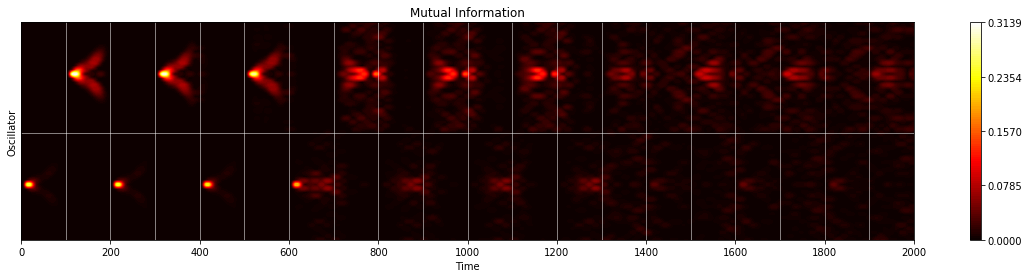

In [5]:
# WM - bath modes (Figure 5)
MutInfLong = np.zeros((NC + NH, Ncycle * (ntC + ntH)))
for cyc in range(Ncycle):
    MutInfLong[:, (ntC+ntH)*cyc:(ntC+ntH)*(cyc+1)] = MutInf[:, :, cyc]
    
t = np.array([n for n in range(2000)])
osc = np.array([n for n in range(60)])
X, Y = np.meshgrid(t, osc)

fig=plt.figure(figsize=(20, 4))
cmap = plt.get_cmap('hot')
levels=np.linspace(MutInfLong.min(), MutInfLong.max(), 100)
contplot = plt.contourf(X, Y, MutInfLong, cmap=cmap, levels=levels)
cb = fig.colorbar(contplot, ticks=np.linspace(MutInfLong.min(), MutInfLong.max(), 5))

plt.xlabel('Time')
plt.ylabel('Oscillator')
plt.title('Mutual Information')
plt.plot((0, 4000), (30, 30), 'w-', linewidth=0.5)
for i in range(1, 20):
    plt.plot((100*i, 100*i), (0, 59), 'w-', linewidth=0.5)

for c in contplot.collections:
    c.set_edgecolor("face")
frame1 = plt.gca()
frame1.yaxis.set_major_locator(plt.NullLocator())
frame1.invert_yaxis()
frame1.axes.set_xlim([0, 2000])
frame1.axes.xaxis.set_ticks([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000])

plt.show()

In [ ]:
# Animation of MI between pairs of oscillators (Figure 6)
%matplotlib
fig = plt.figure(1)
ax  = fig.add_subplot(111)
im  = ax.imshow(MutInfLattice[:, :, 0]) # Starting image
fig.show()
im.axes.figure.canvas.draw()

for frame in range(MutInfLattice.shape[2]):
    im.set_data(MutInfLattice[:, :, frame])
    im.axes.figure.canvas.draw()